In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import pickle
import numpy as np
import scipy
import torch
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

import base_network as base_net
import ring_network as network
import sim_util as su
import ricciardi as ric
import integrate as integ

def imshowbar(fig,ax,A,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(imsh, cax=cax, orientation='vertical')
    return cbar

# Simulate Best Fit

In [3]:
# id = (133, 0, 52, 0)
# id = (133,0)
id = None
if id is None:
    with open('./../results/best_fit.pkl', 'rb') as handle:
        res_dict = pickle.load(handle)
        fit_res_dict = res_dict.copy()
elif len(id)==2:
    with open('./../results/results_ring_{:d}.pkl'.format(
            id[0]), 'rb') as handle:
        res_dict = pickle.load(handle)[id[-1]]
        fit_res_dict = res_dict.copy()
else:
    with open('./../results/results_ring_perturb_njob-{:d}_nrep-{:d}_ntry-{:d}.pkl'.format(
            id[0],id[1],id[2]), 'rb') as handle:
        res_dict = pickle.load(handle)[id[-1]]
        fit_res_dict = res_dict.copy()
prms = res_dict['prms']
eX = res_dict['best_monk_eX']
bX = res_dict['best_monk_bX']
aXs = res_dict['best_monk_aXs']
K = prms['K']
SoriE = prms['SoriE']
SoriI = prms['SoriI']
SoriF = prms['SoriF']
J = prms['J']
beta = prms['beta']
gE = prms['gE']
gI = prms['gI']
hE = prms['hE']
hI = prms['hI']
L = prms['L']
CVL = prms['CVL']

ri = ric.Ricciardi()
ri.set_up_nonlinearity('./../scripts/phi_int')
ri.set_up_nonlinearity_tensor()

NtE = 50
Nt = NtE*ri.tE
dt = ri.tI/5
T = torch.linspace(0,8*Nt,round(8*Nt/dt)+1)
mask_time = T>(4*Nt)
T_mask = T.cpu().numpy()[mask_time]

N = 10000
Nori = 20
NE = 4*(N//Nori)//5
NI = 1*(N//Nori)//5

this_prms = prms.copy()
this_prms['Nori'] = Nori
this_prms['NE'] = NE
this_prms['NI'] = NI

Loading previously saved nonlinearity
Using cpu


In [4]:
reload(su)

start = time.process_time()

net,M,H,B,LAS,eps = su.gen_ring_disorder_tensor(0,this_prms,eX)

Inp = (bX*B+aXs[-1]*H)*eps

print("Generating disorder took ",time.process_time() - start," s")
print('')

# start = time.process_time()

# sol,_ = integ.sim_dyn_tensor(ri,T,0.0,M,Inp,LAS,net.C_conds[0],mult_tau=True)
# rates = torch.mean(sol[:,mask_time],axis=1).cpu().numpy()

# np.save('best_fit_vis_rates',rates)

# print("Integrating network took ",time.process_time() - start," s")
# print('')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rates = np.load('best_fit_vis_rates.npy')

Using cpu
Generating disorder took  17.171988  s



# Arrange Neurons

In [5]:
radEring = 20
radIring = 10
radEpop = 2
radIpop = 1

Nperori = N//Nori
pts = np.zeros((N,2))
pops = np.zeros(N).astype(int)
colors = [None,]*N

rng = np.random.default_rng(0)
for i in range(net.N):
    locidx = i//Nperori
    popidx = 0 if (i%Nperori) < net.NC[0] else 1
    pops[i] = popidx
    colors[i] = ['r','b'][popidx]
    
    r = np.sqrt(rng.random())
    tht = rng.random()*2*np.pi
    
    if popidx==0:
        pts[i,0] = radEring*np.cos(2*np.pi*locidx/Nori) + radEpop*r*np.cos(tht)
        pts[i,1] = radEring*np.sin(2*np.pi*locidx/Nori) + radEpop*r*np.sin(tht)
    else:
        pts[i,0] = radIring*np.cos(2*np.pi*locidx/Nori) + radIpop*r*np.cos(tht)
        pts[i,1] = radIring*np.sin(2*np.pi*locidx/Nori) + radIpop*r*np.sin(tht)

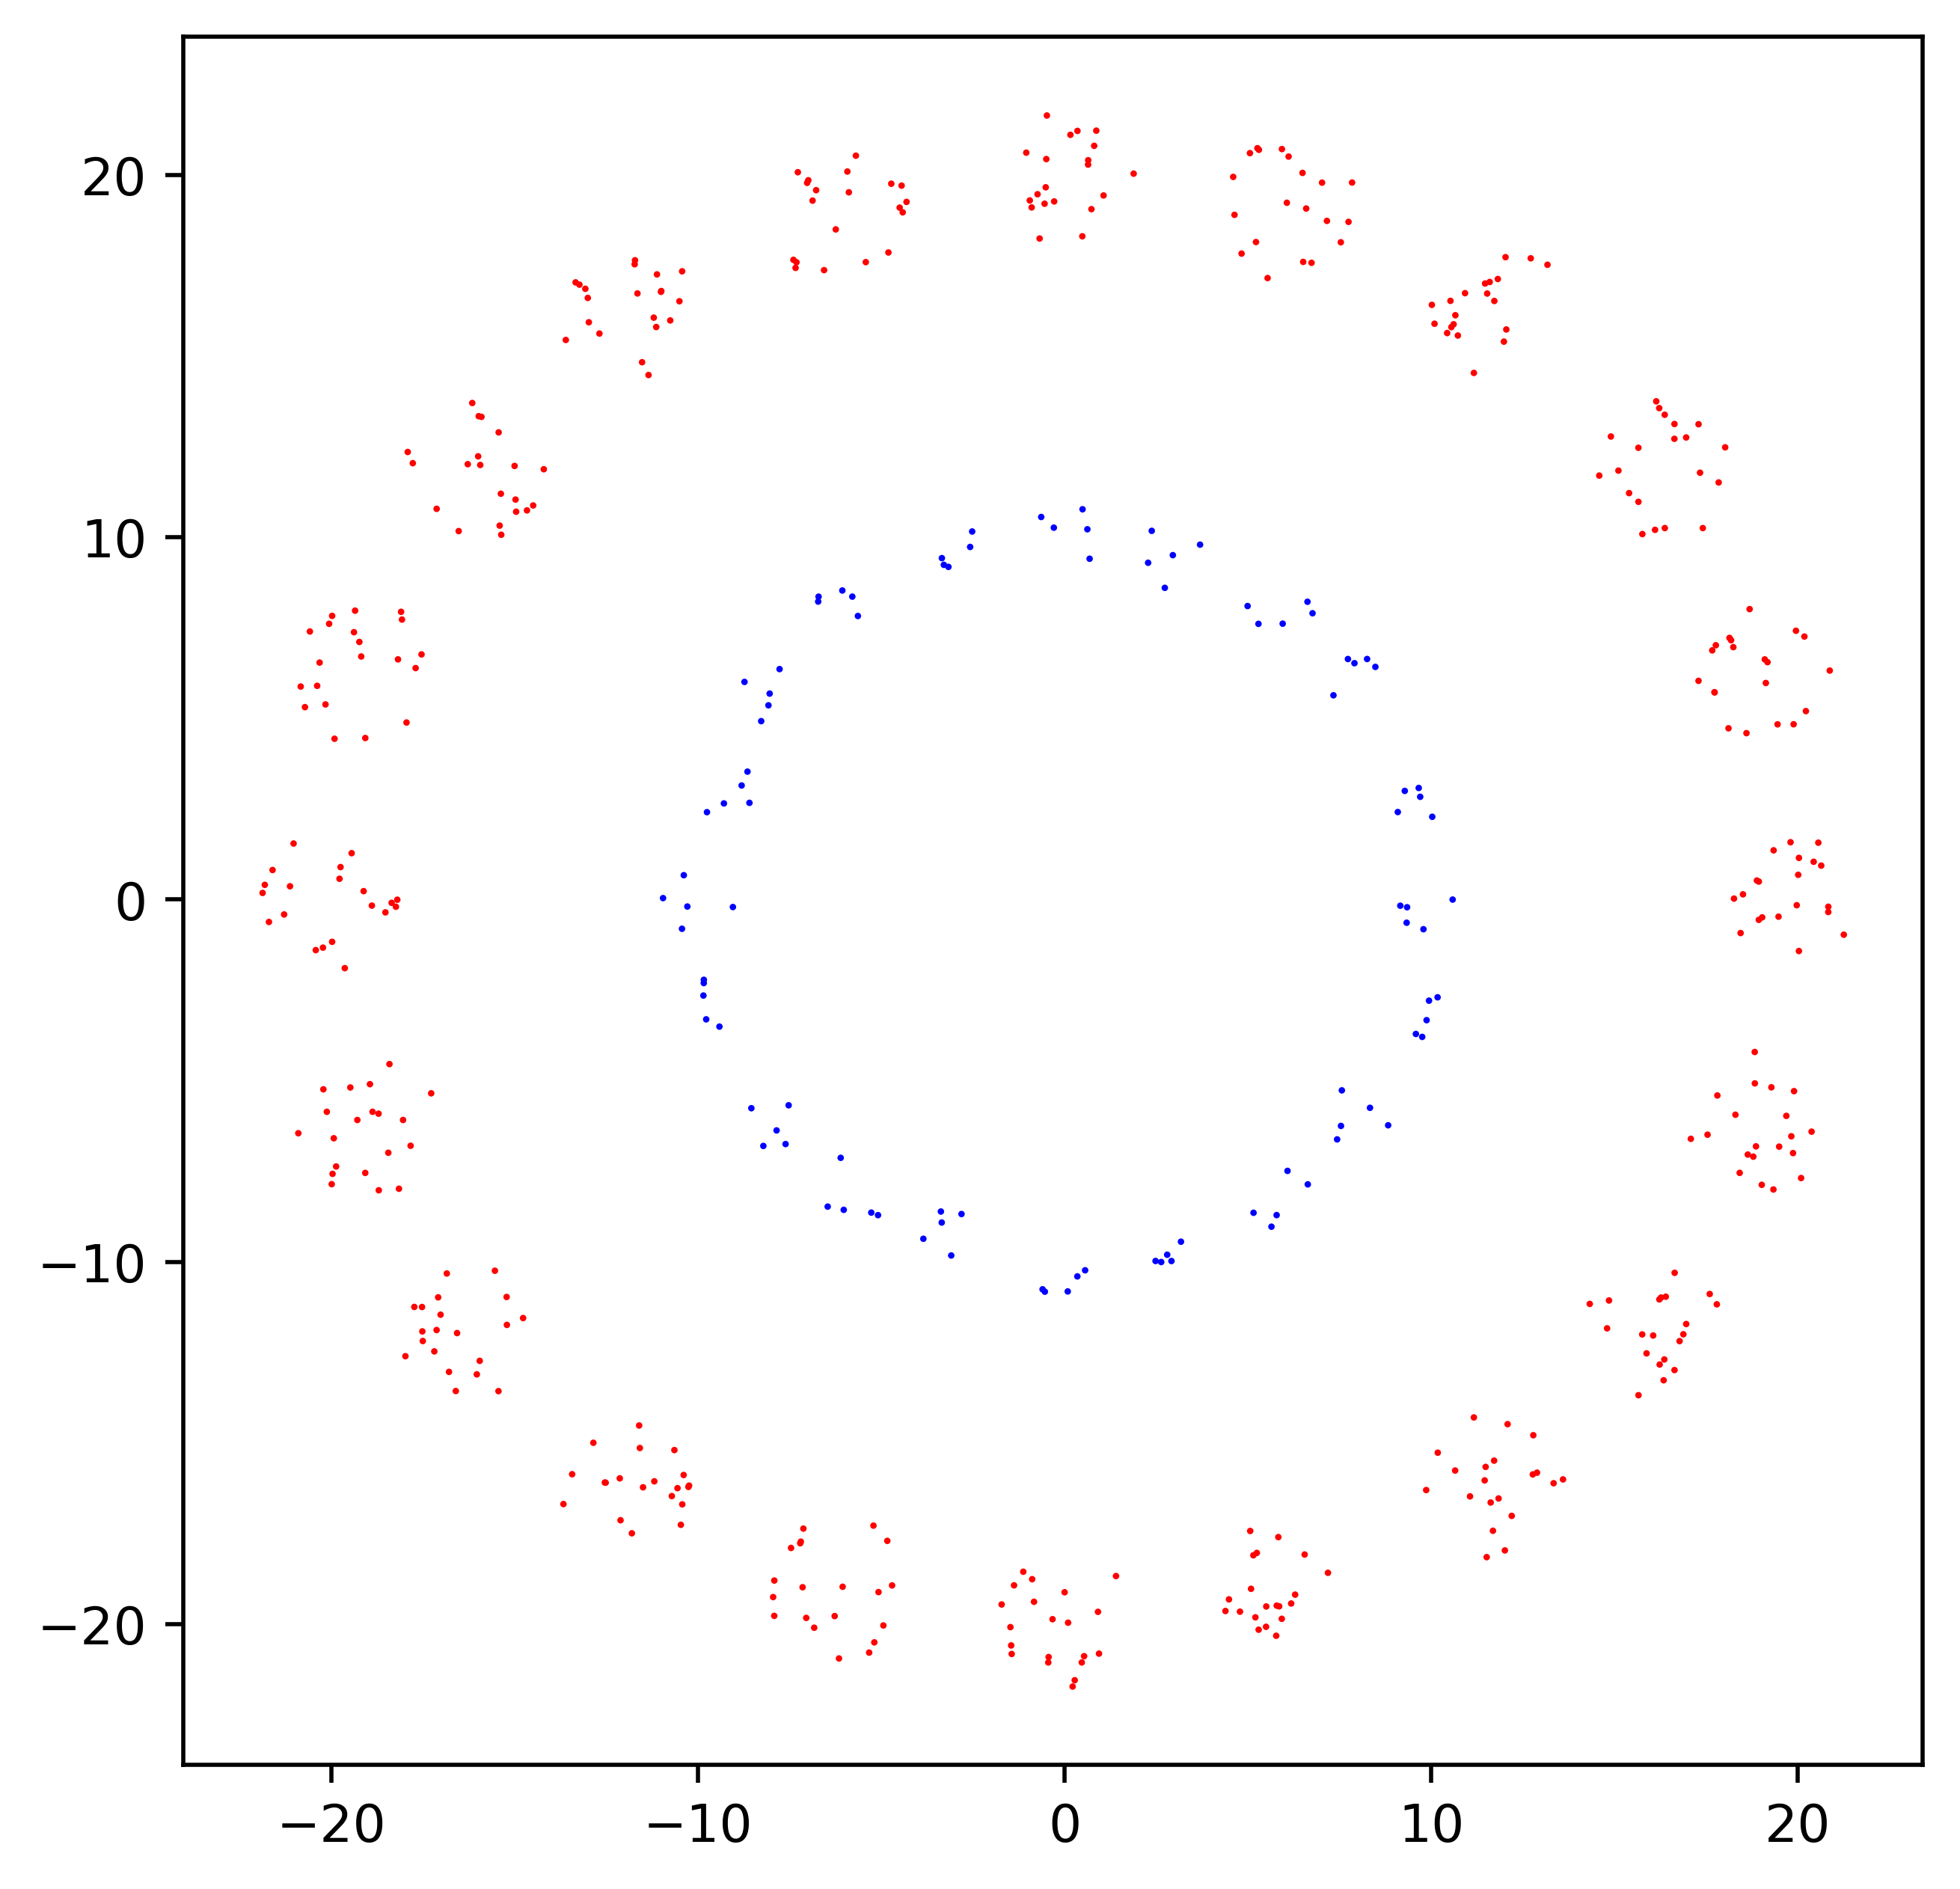

In [6]:
fig,axs = plt.subplots(1,1,figsize=(6,6),dpi=500)

skip = 20
s = 1
axs.scatter(pts[::skip,0],pts[::skip,1],s=s,lw=s/4,c=colors[::skip])

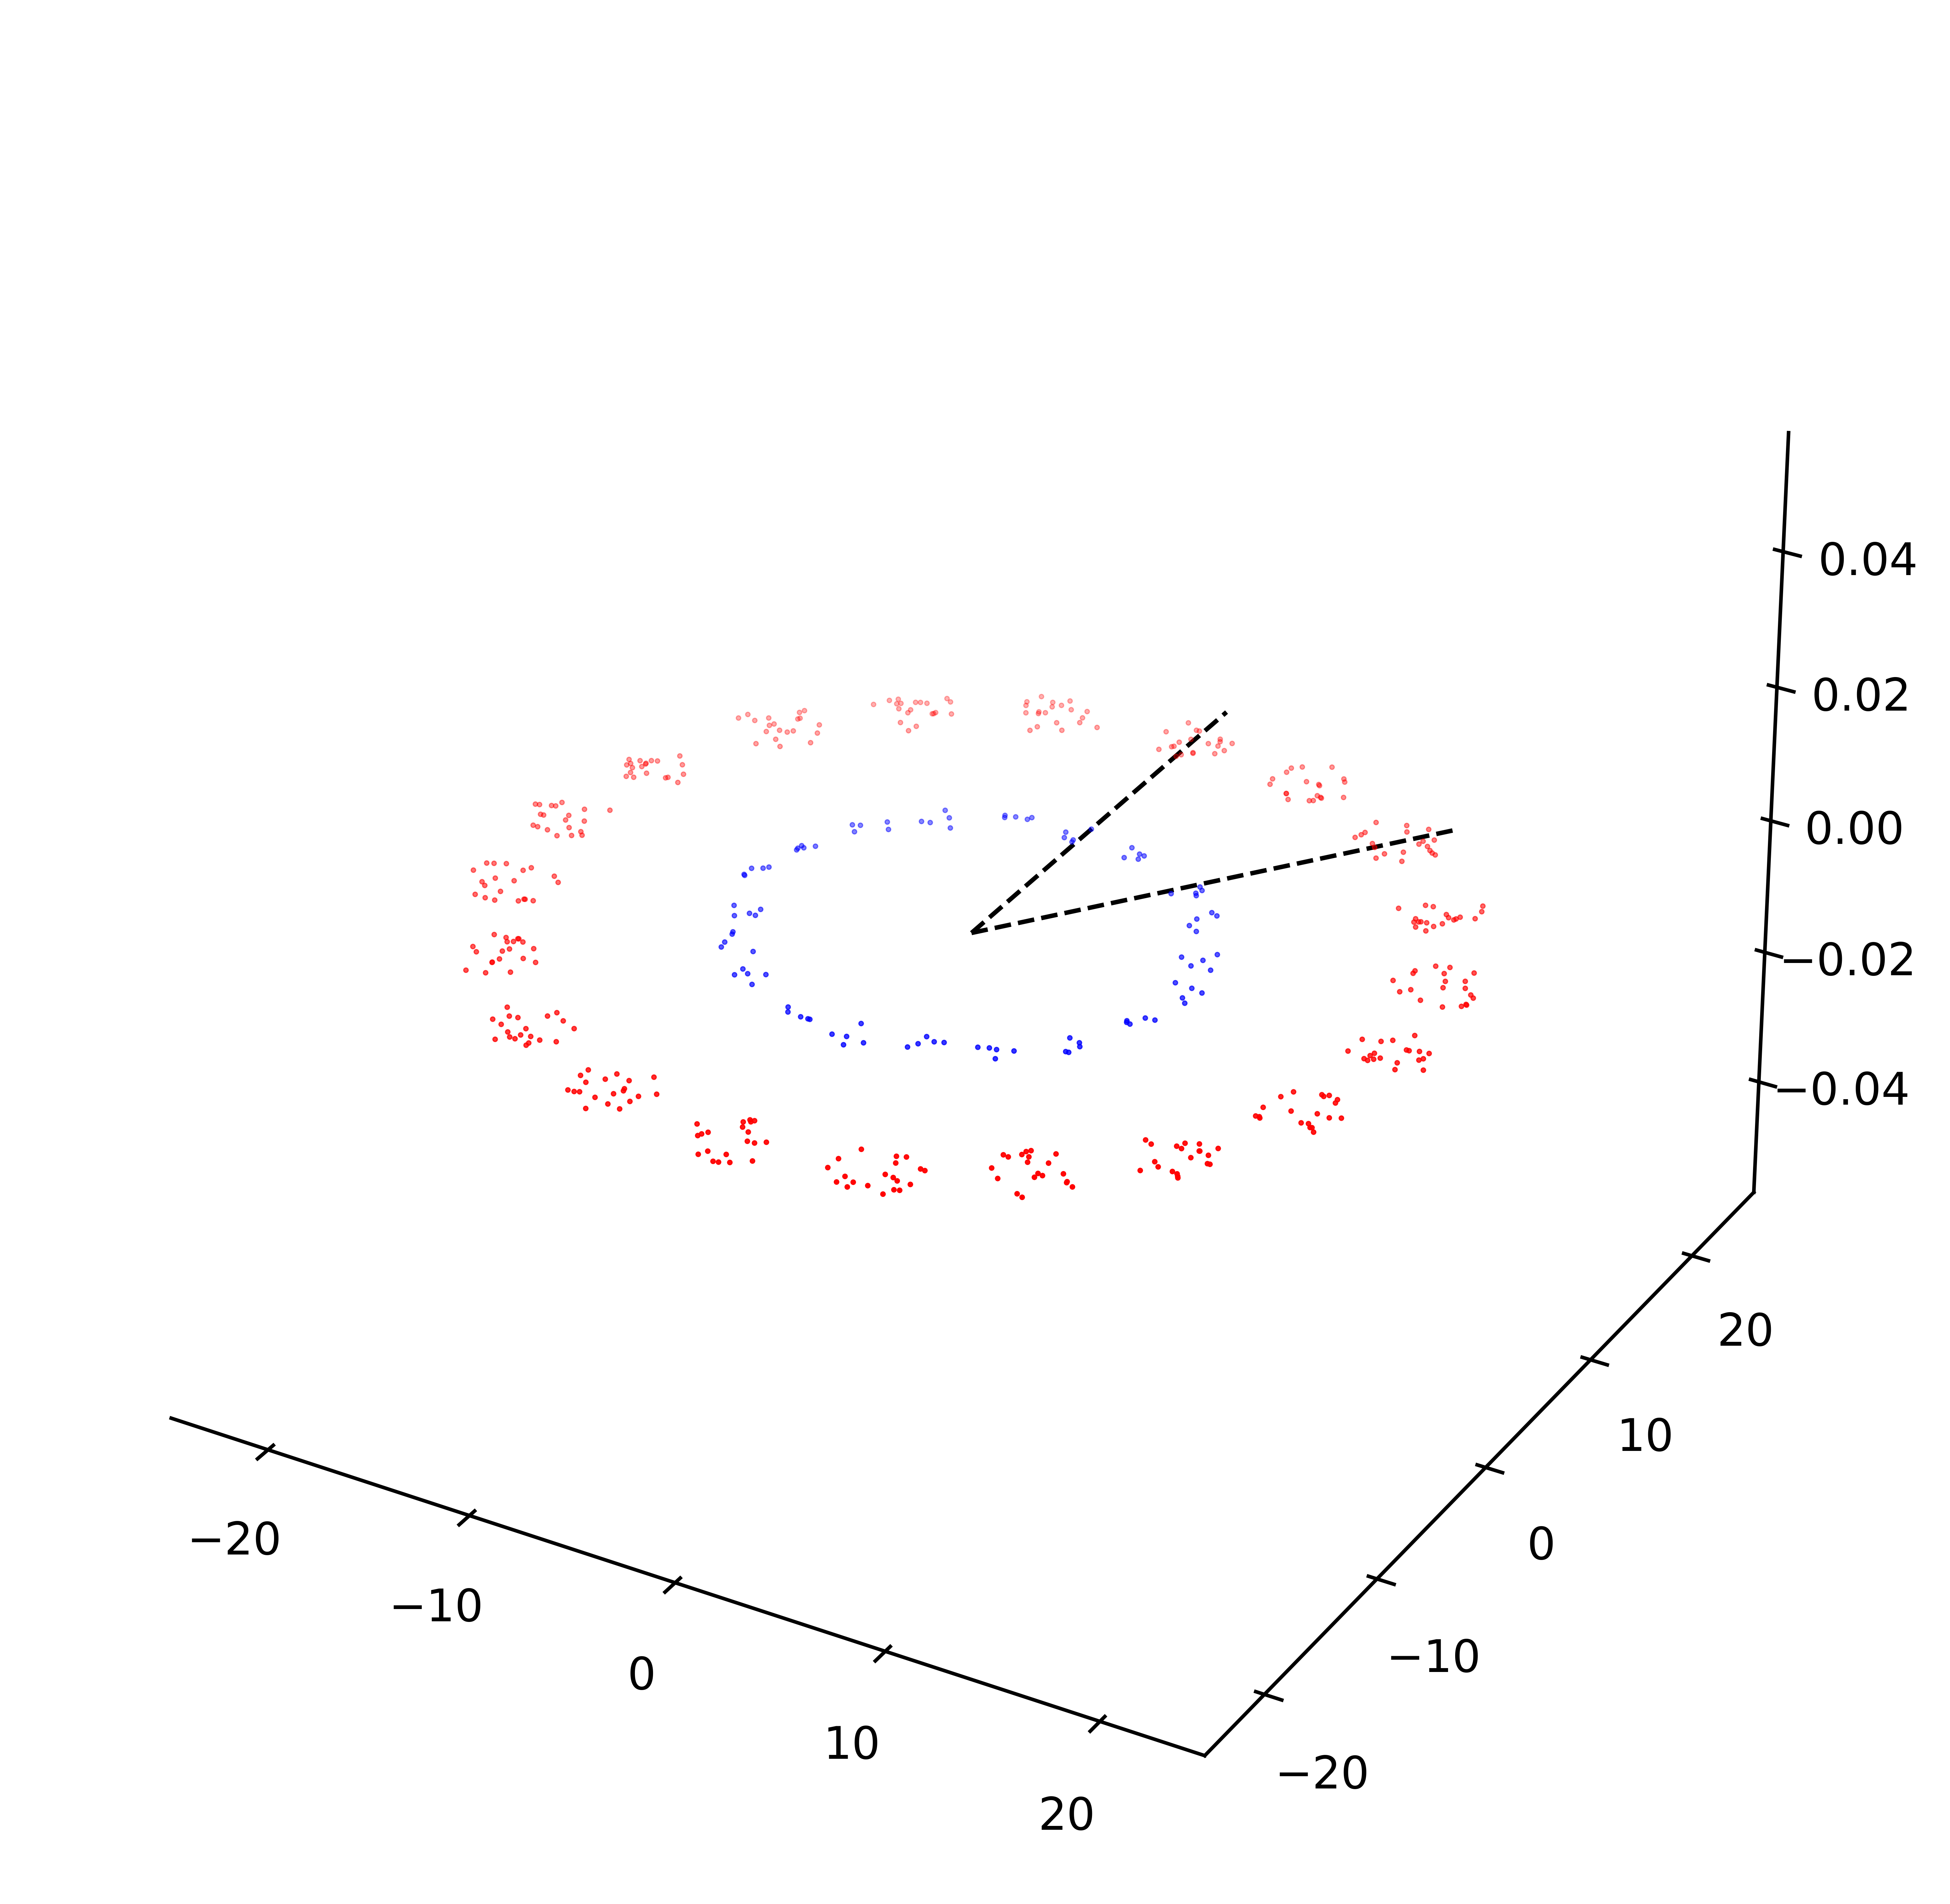

In [22]:
fig,ax = plt.subplots(1,1,figsize=(6,6),dpi=1000,subplot_kw=dict(projection='3d'))

skip = 20
s = 1
ax.scatter(pts[::skip,1],pts[::skip,0],np.zeros(net.N//skip),s=s,lw=s/4,c=colors[::skip])
ax.plot([0,0],[0,radEring+radEpop*1.5],[0,0],'k--',lw=s)
ax.plot([0,(radEring+radEpop*1.5)*np.sin(2*2*np.pi/net.Nori)],
        [0,(radEring+radEpop*1.5)*np.cos(2*2*np.pi/net.Nori)],[0,0],'k--',lw=s)

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

fig.tight_layout()
fig.savefig('./../plots/ring_model_sites.pdf')

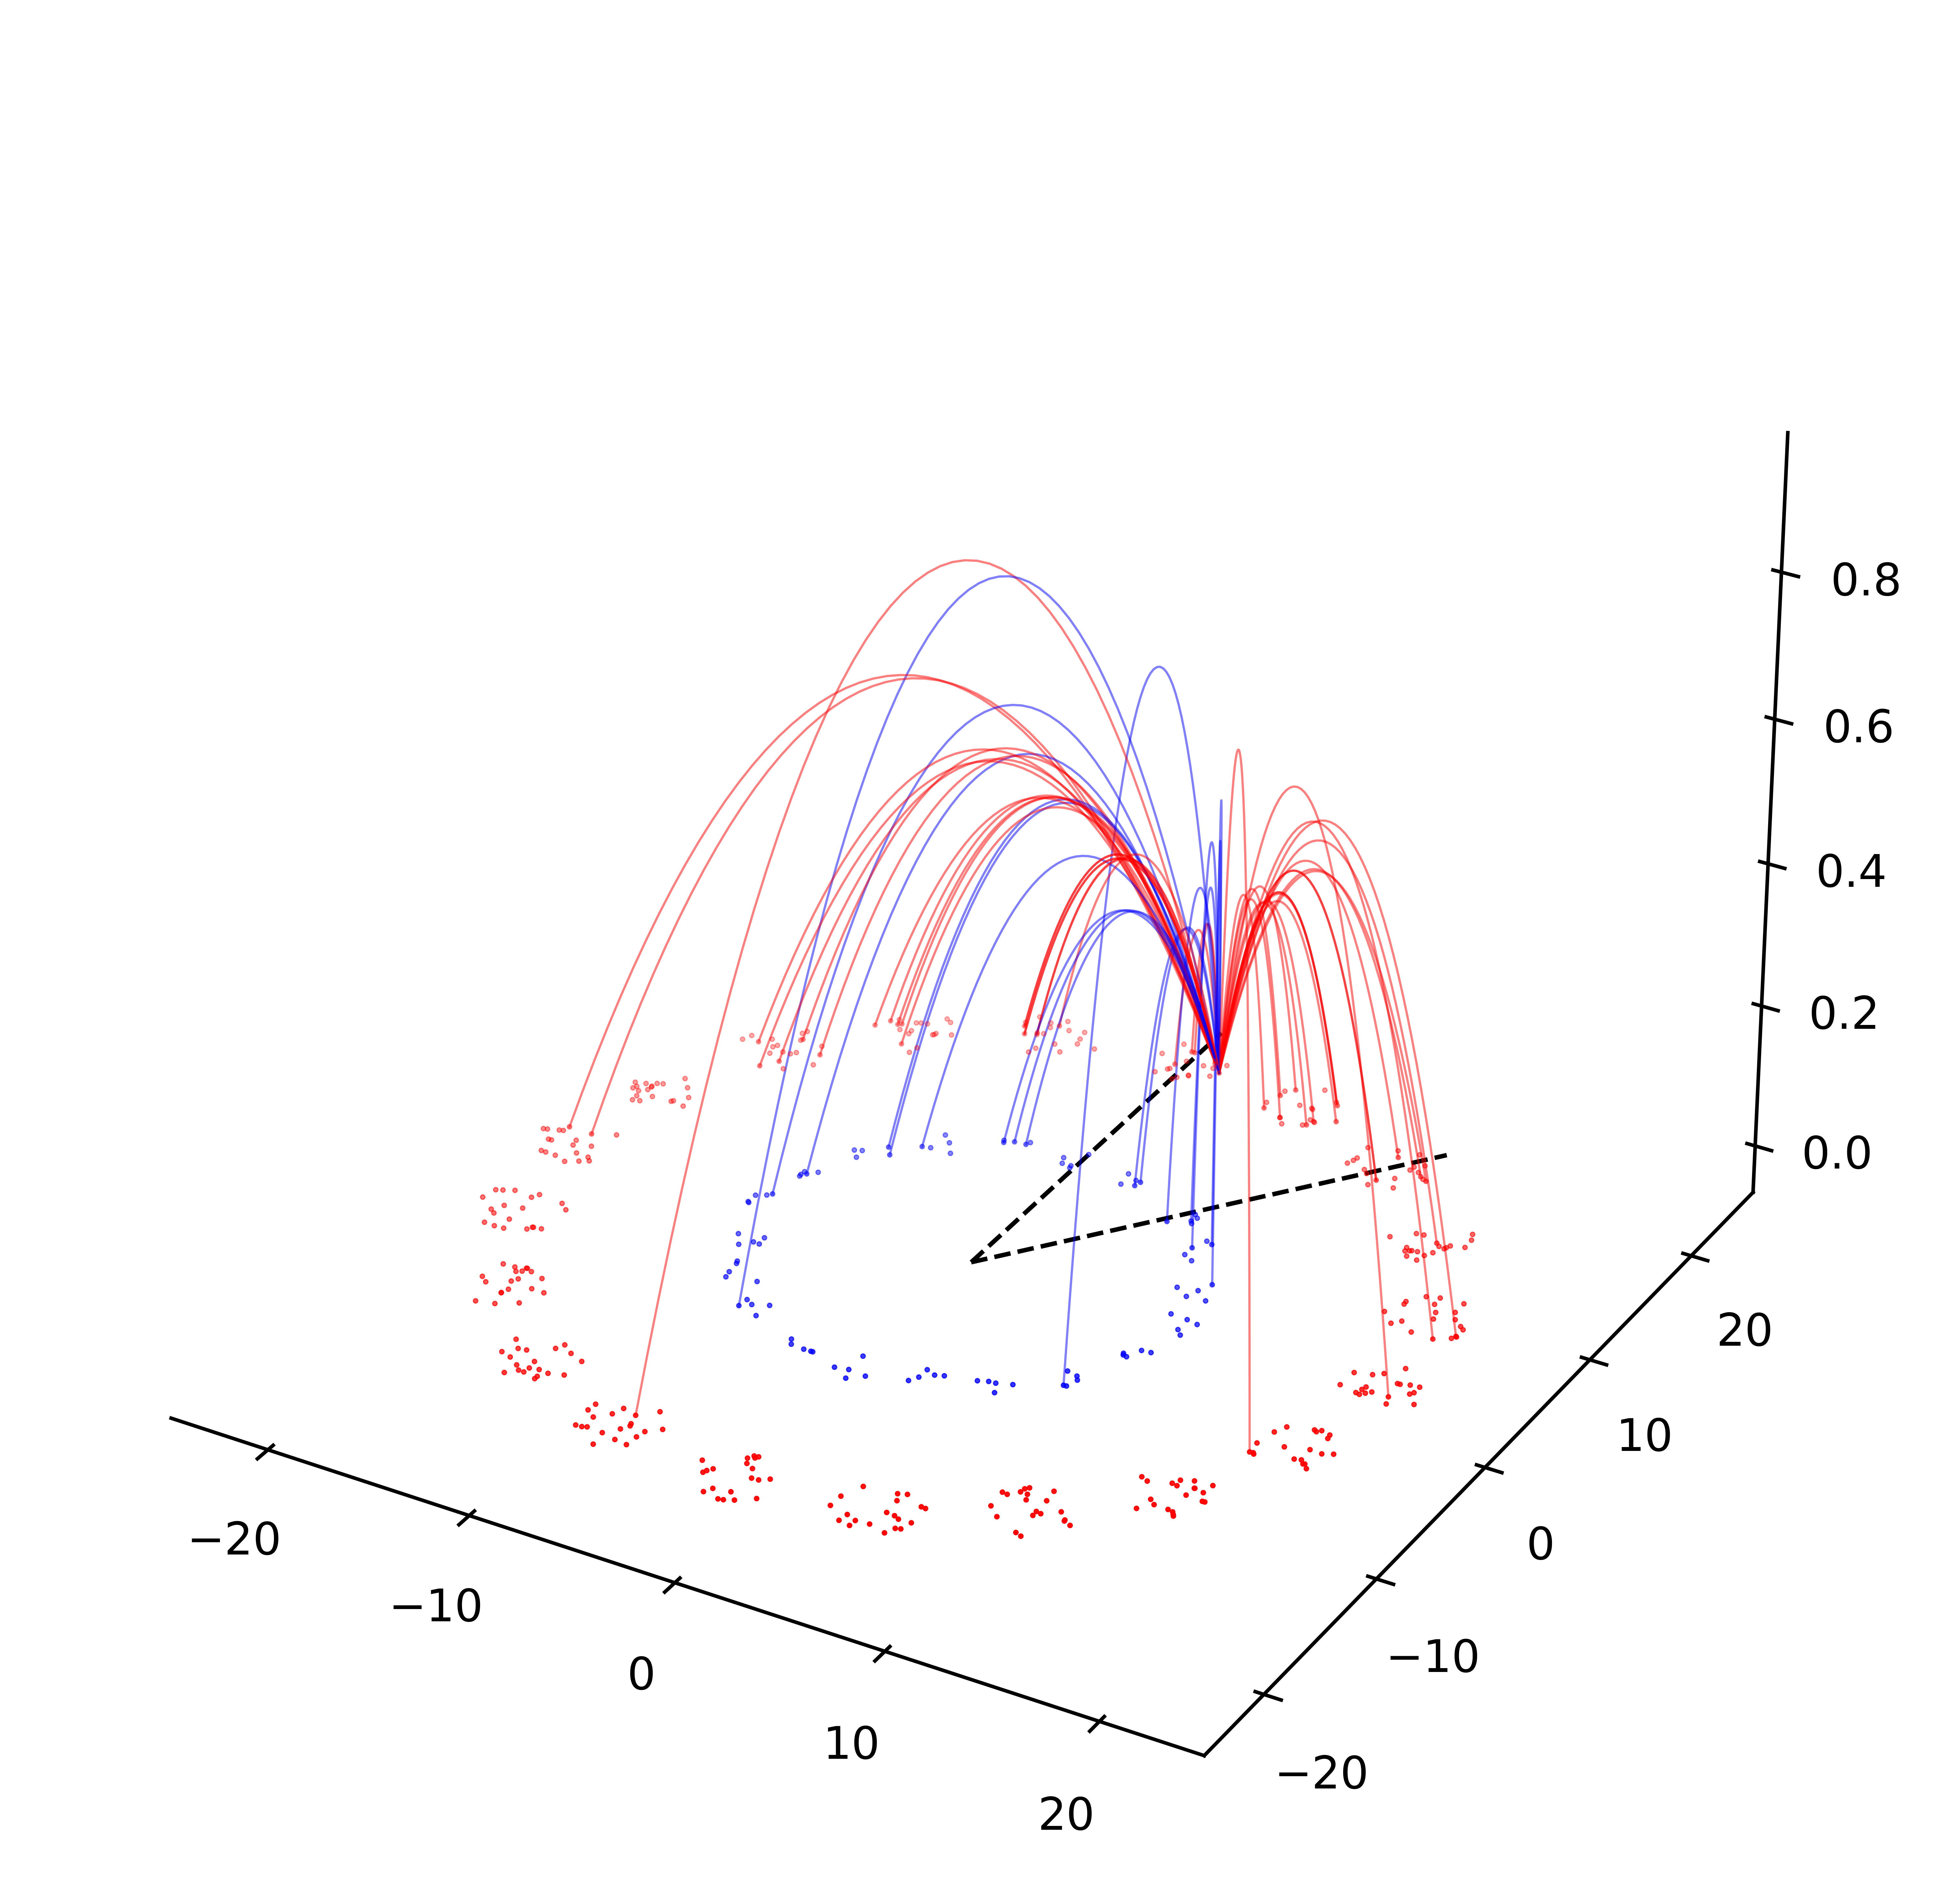

In [32]:
fig,ax = plt.subplots(1,1,figsize=(6,6),dpi=1000,subplot_kw=dict(projection='3d'))

skip = 20
s = 1
npts = 50
ax.scatter(pts[::skip,1],pts[::skip,0],np.zeros(net.N//skip),s=s,lw=s/4,c=colors[::skip])
ax.plot([0,0],[0,radEring+radEpop*1.5],[0,0],'k--',lw=s)
ax.plot([0,(radEring+radEpop*1.5)*np.sin(2*2*np.pi/net.Nori)],
        [0,(radEring+radEpop*1.5)*np.cos(2*2*np.pi/net.Nori)],[0,0],'k--',lw=s)
for i in range(0,net.N,skip):
    h = (i//Nperori)/Nori
    if h < 0.5: h = 1-h
    h = 2*(h-0.5)
    h = np.sqrt(1 - 0.8*h)
    reps = [2,3]
    for j in reps:
        if np.abs(net.M[i,j*skip]) > 1e-12:
                ax.plot(np.linspace(pts[0,1],pts[i,1],npts),
                        np.linspace(pts[0,0],pts[i,0],npts),
                        h**2-np.linspace(-h,h,npts)**2,colors[i],lw=s/2,alpha=0.5)

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

fig.tight_layout()
fig.savefig('./../plots/ring_model_conn.pdf')

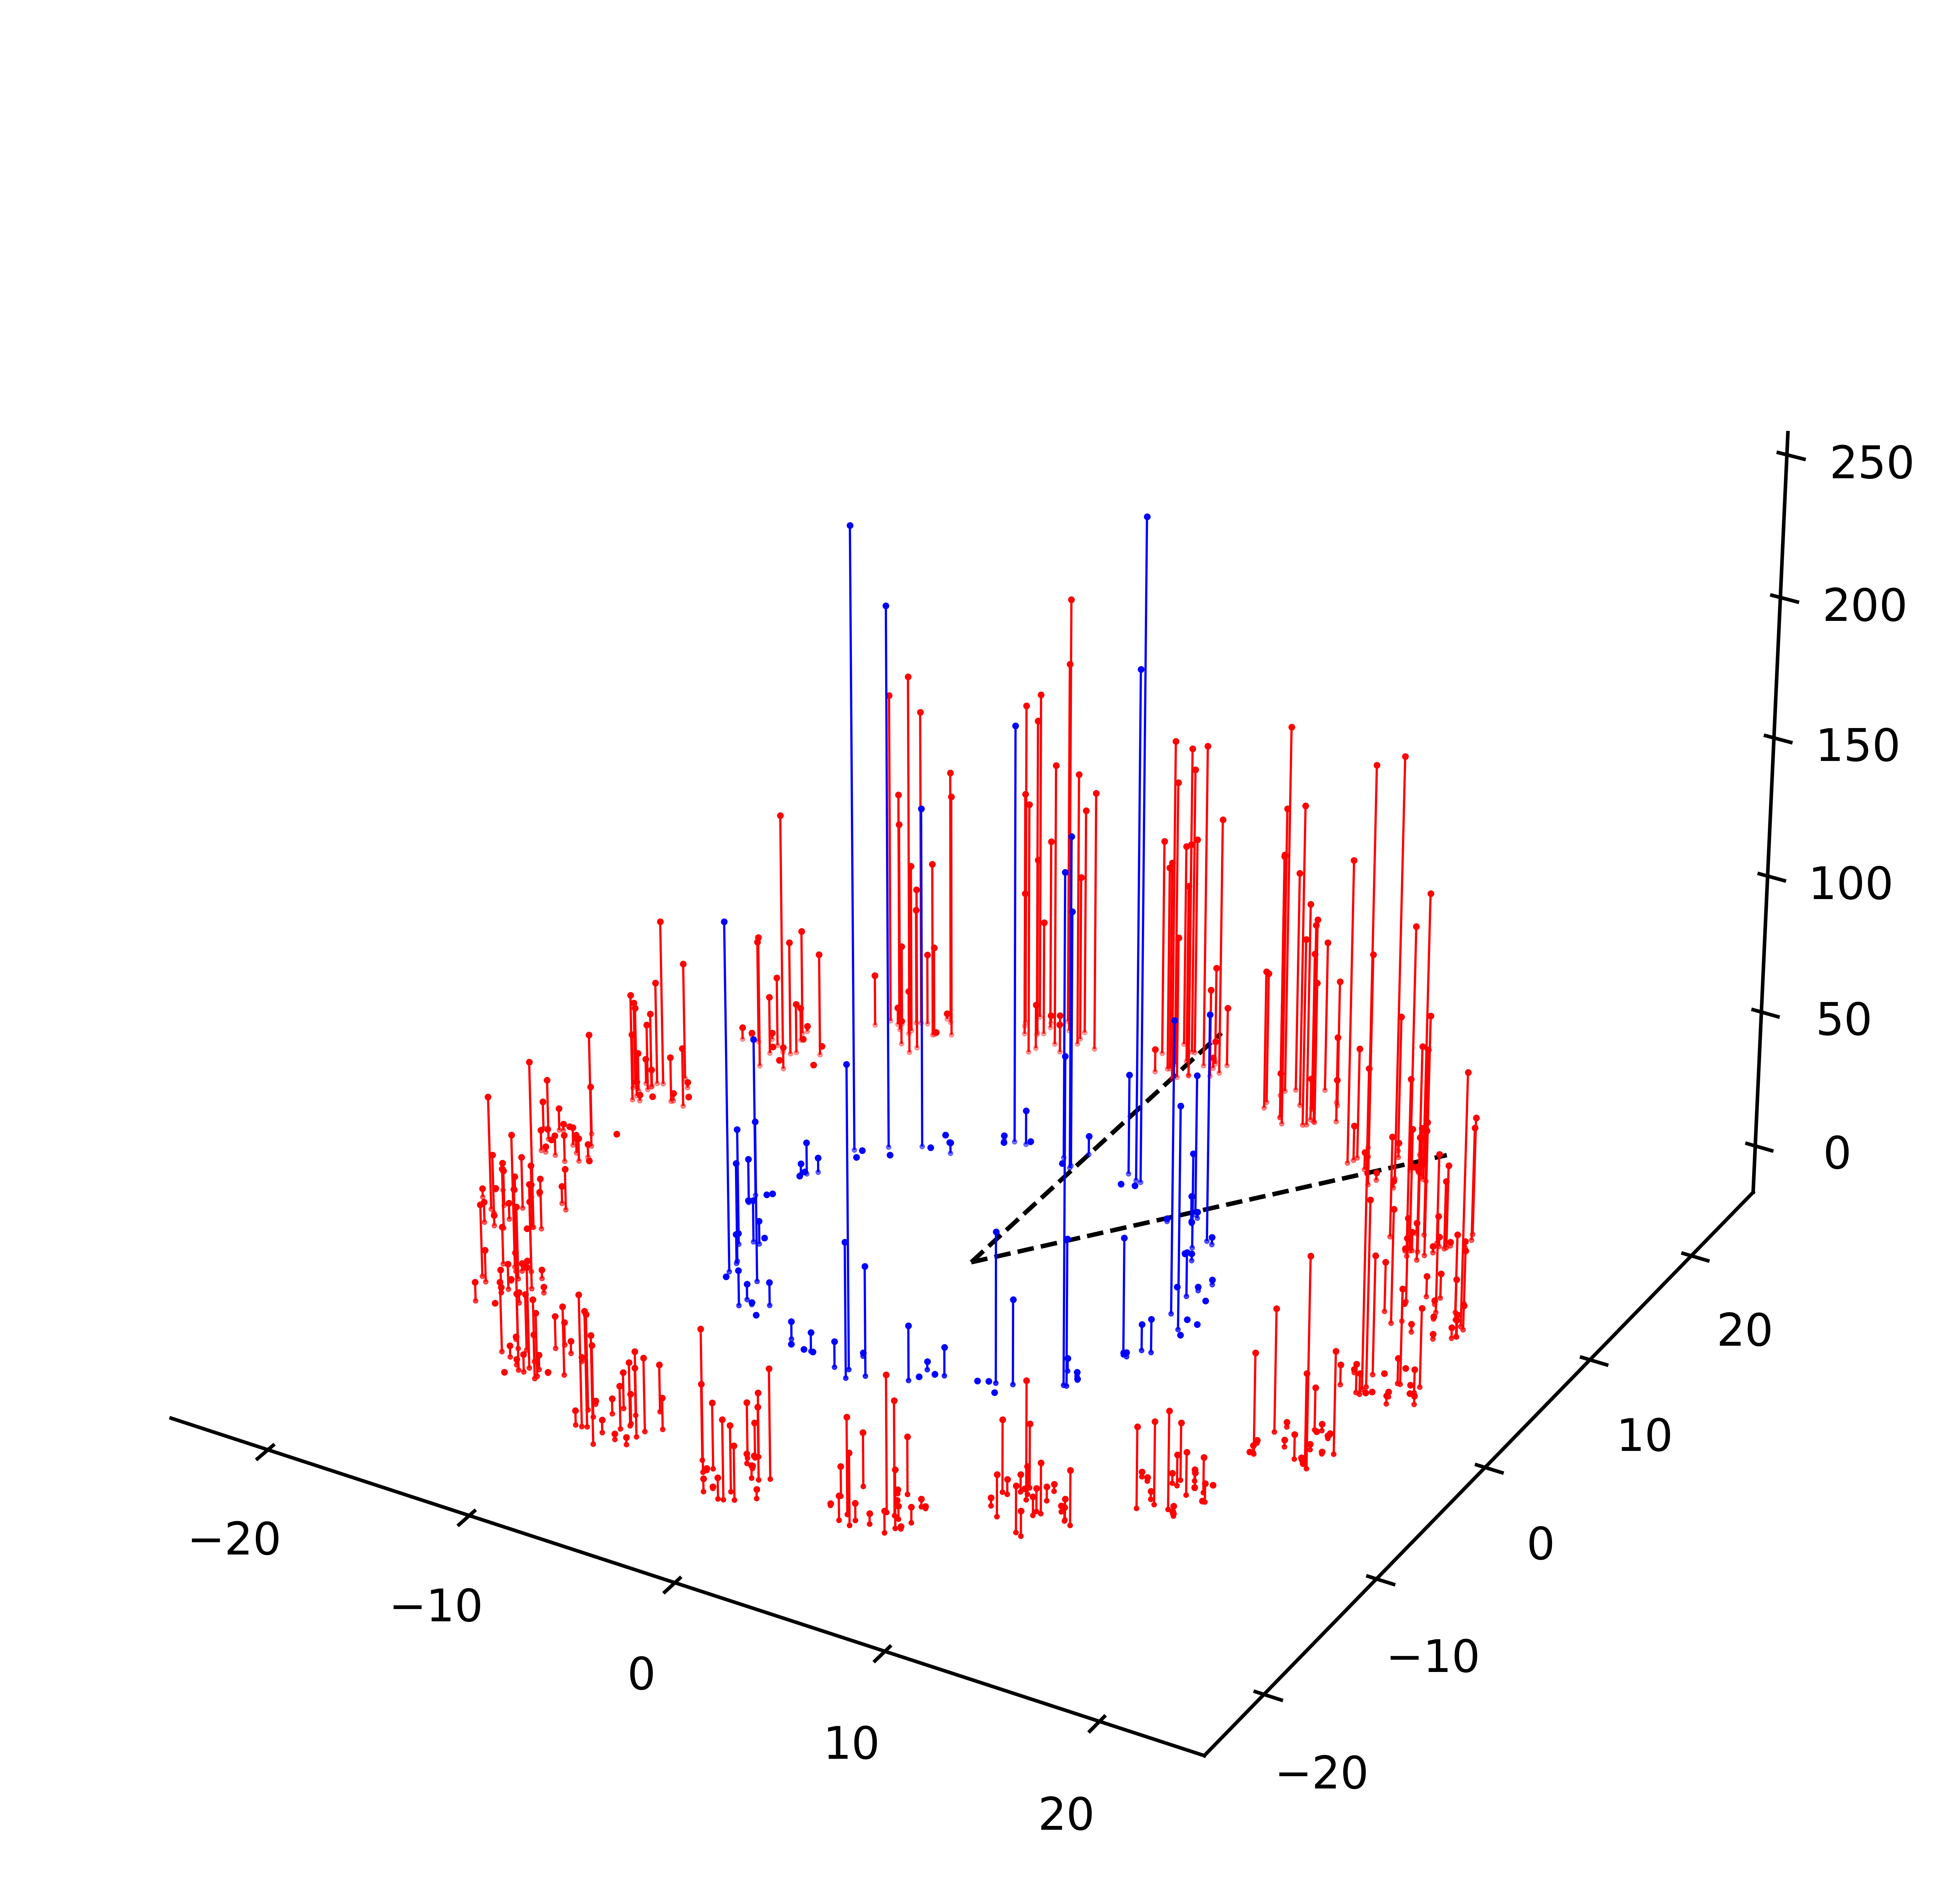

In [24]:
fig,ax = plt.subplots(1,1,figsize=(6,6),dpi=1000,subplot_kw=dict(projection='3d',computed_zorder=False))

skip = 20
s = 1
ax.scatter(pts[::skip,1],pts[::skip,0],np.zeros(net.N//skip),s=s,lw=s/4,c=colors[::skip])
ax.plot([0,0],[0,radEring+radEpop*1.5],[0,0],'k--',lw=s,zorder=0)
ax.plot([0,(radEring+radEpop*1.5)*np.sin(2*2*np.pi/net.Nori)],
        [0,(radEring+radEpop*1.5)*np.cos(2*2*np.pi/net.Nori)],[0,0],'k--',lw=s,zorder=0)
Emarkerline,Estemline,Ebaseline = ax.stem(pts[net.C_all[0],1][::skip],pts[net.C_all[0],0][::skip],
                                            rates[net.C_all[0]][::skip])
Imarkerline,Istemline,Ibaseline = ax.stem(pts[net.C_all[1],1][::skip],pts[net.C_all[1],0][::skip],
                                            rates[net.C_all[1]][::skip])
plt.setp(Ebaseline,linewidth = 0)
plt.setp(Ibaseline,linewidth = 0)
plt.setp(Estemline,linewidth = s/2,color='r',zorder=1)
plt.setp(Istemline,linewidth = s/2,color='b',zorder=2)
plt.setp(Emarkerline,markersize = s/2,color='r',zorder=1)
plt.setp(Imarkerline,markersize = s/2,color='b',zorder=2)

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

fig.tight_layout()
fig.savefig('./../plots/ring_model_rates.pdf')

In [33]:
import matplotlib.image as mpimg
Eimg = mpimg.imread('./../plots/Efig.png')
Iimg = mpimg.imread('./../plots/Ifig.png')

Exmesh,Eymesh = np.meshgrid(np.linspace(-1,1,Eimg.shape[0]),np.linspace(-1,1,Eimg.shape[1]))
Ixmesh,Iymesh = np.meshgrid(np.linspace(-1,1,Iimg.shape[0]),np.linspace(-1,1,Iimg.shape[1]))
Ezmesh = np.zeros_like(Exmesh)
Izmesh = np.zeros_like(Ixmesh)

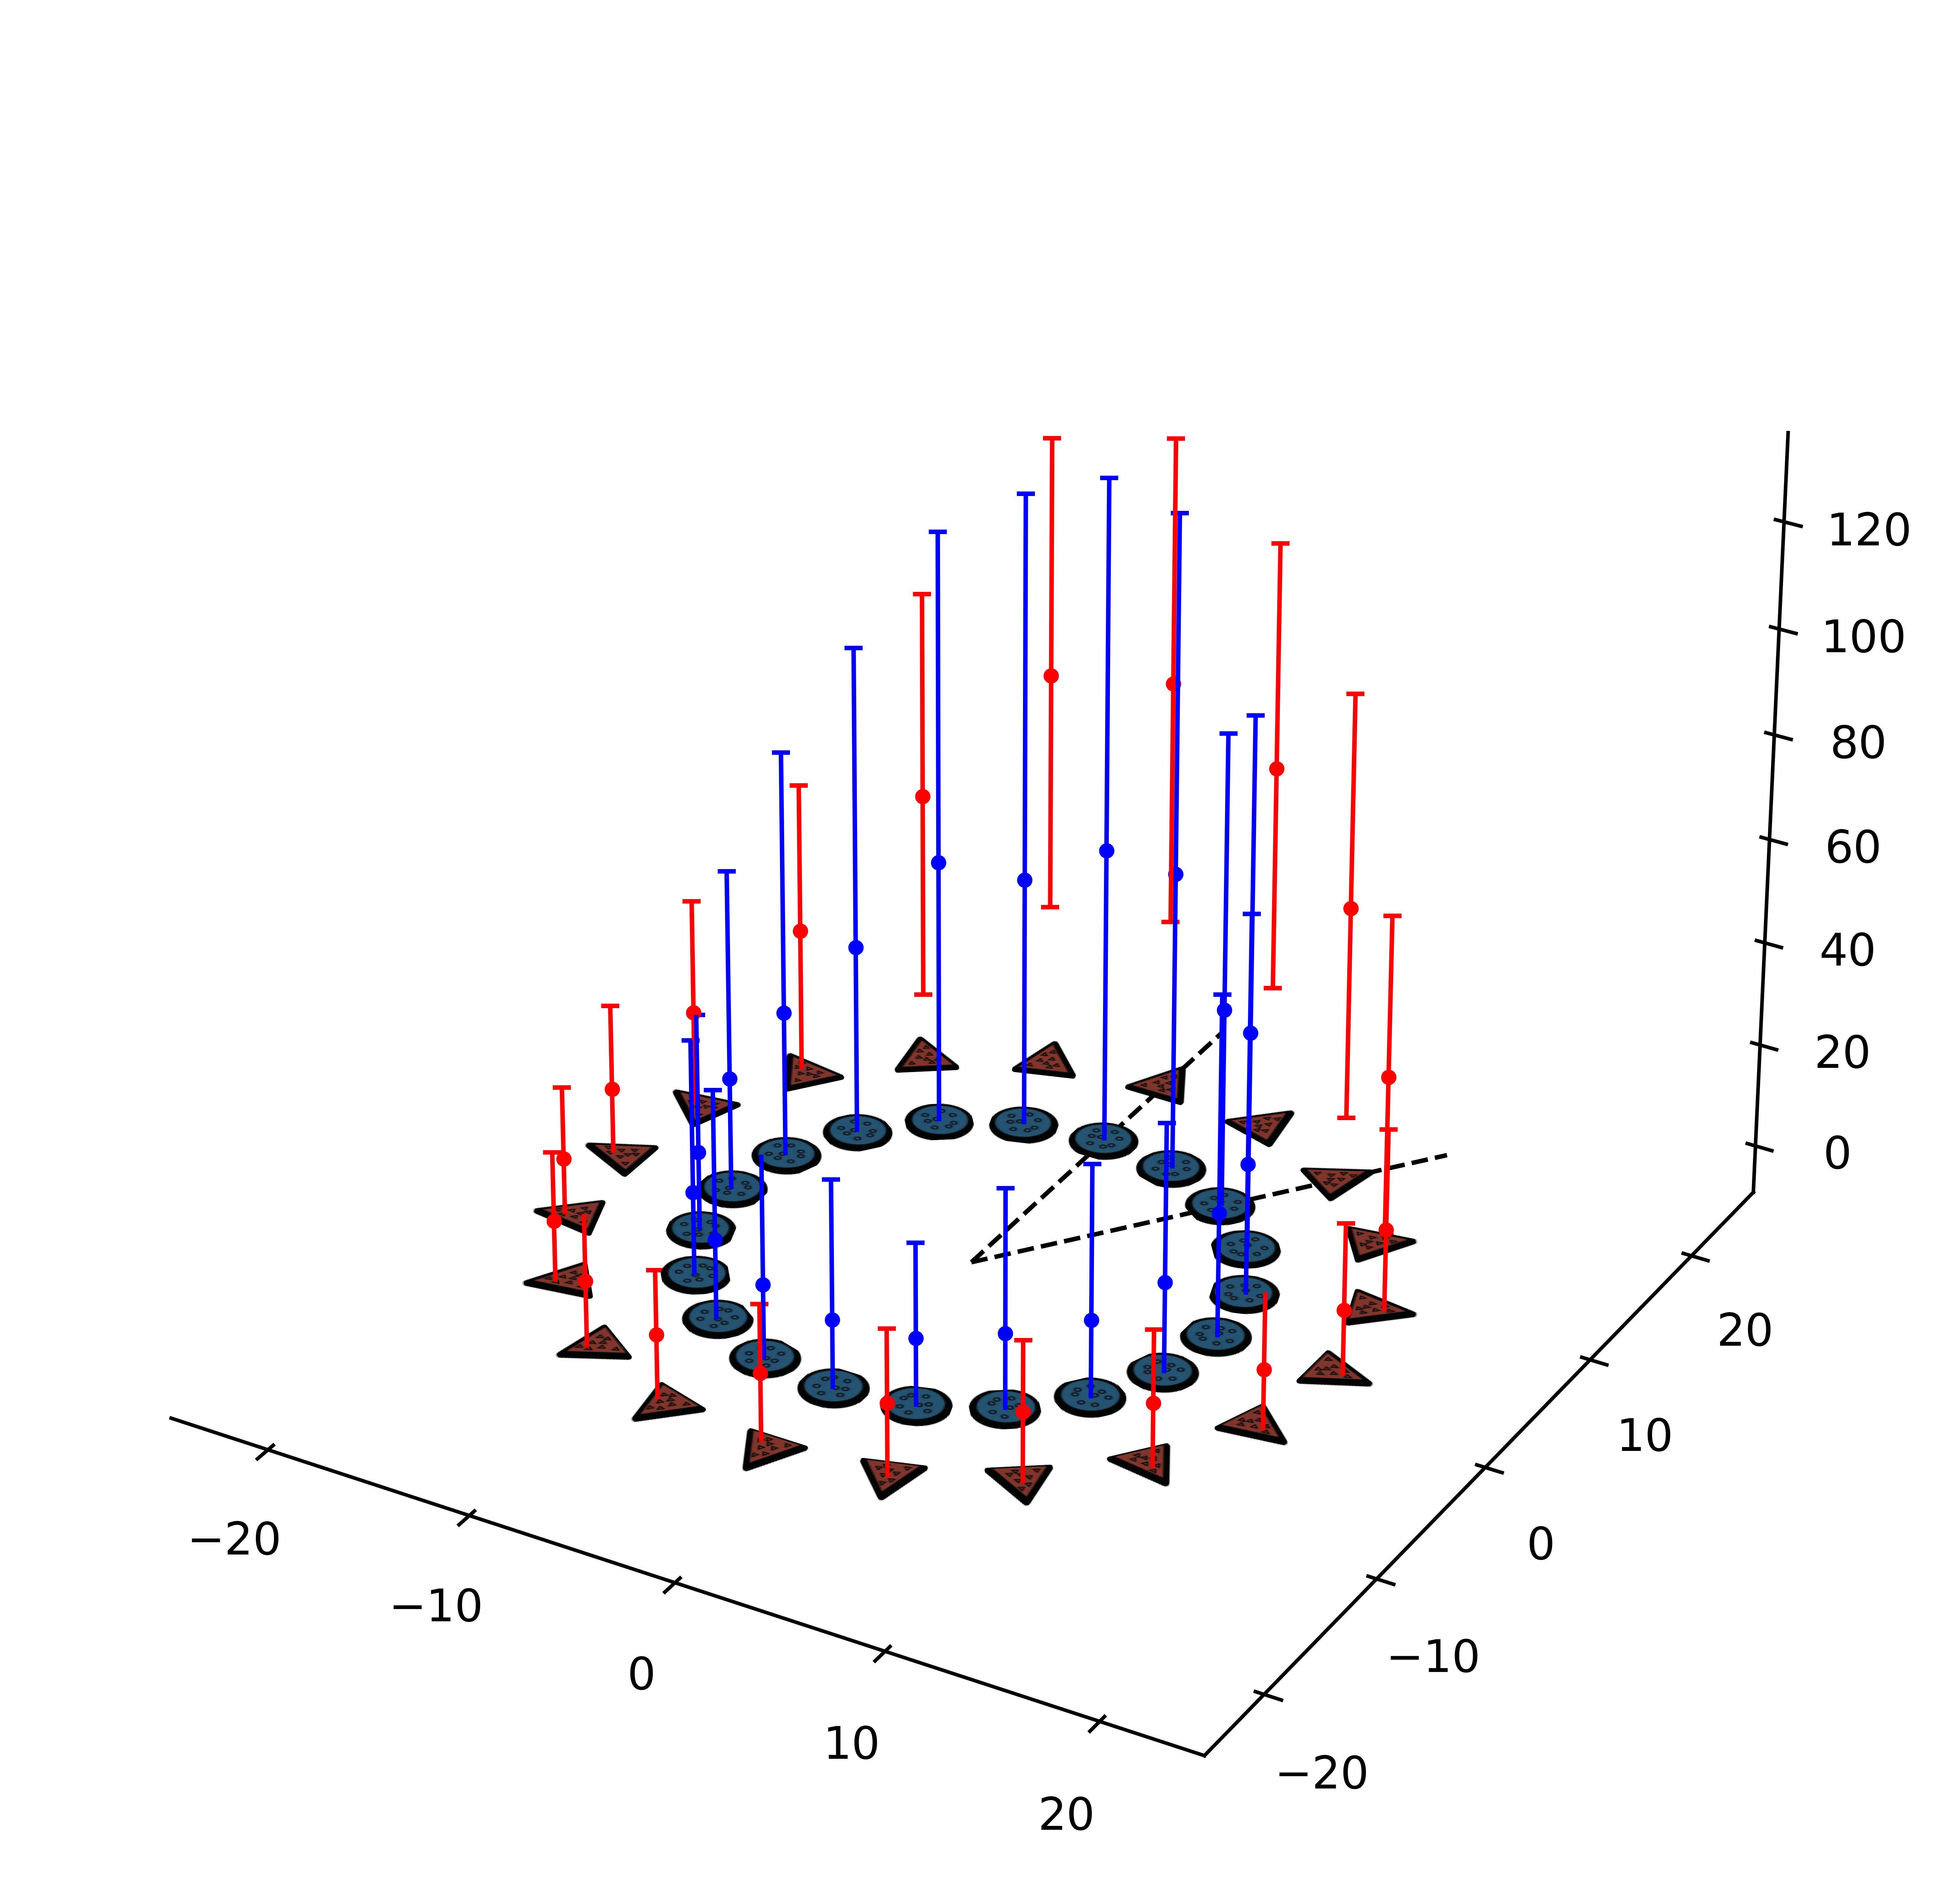

In [34]:
fig,ax = plt.subplots(1,1,figsize=(6,6),dpi=1000,subplot_kw=dict(projection='3d'))

skip = 20
s = 1
ax.scatter(pts[::skip,1],pts[::skip,0],np.zeros(net.N//skip),s=s,lw=s/4,c=colors[::skip],alpha=1e-12)
ax.plot([0,0],[0,radEring+radEpop*1.5],[0,0],'k--',lw=s,zorder=0)
ax.plot([0,(radEring+radEpop*1.5)*np.sin(2*2*np.pi/net.Nori)],
        [0,(radEring+radEpop*1.5)*np.cos(2*2*np.pi/net.Nori)],[0,0],'k--',lw=s,zorder=0)
for locidx in range(Nori):
    rotang = -np.pi/2 - 2*np.pi*locidx/Nori
    ax.plot_surface(0.9*radEring*np.sin(2*np.pi*locidx/Nori)+1.4*radIpop*(np.cos(rotang)*Eymesh-np.sin(rotang)*Exmesh),
                    0.9*radEring*np.cos(2*np.pi*locidx/Nori)+1.4*radIpop*(np.sin(rotang)*Eymesh+np.cos(rotang)*Exmesh),
                    Ezmesh,rstride=1,cstride=1,facecolors=Eimg)
    ax.plot_surface(1.2*radIring*np.sin(2*np.pi*locidx/Nori)+1.4*radIpop*(np.cos(rotang)*Iymesh-np.sin(rotang)*Ixmesh),
                    1.2*radIring*np.cos(2*np.pi*locidx/Nori)+1.4*radIpop*(np.sin(rotang)*Iymesh+np.cos(rotang)*Ixmesh),
                    Izmesh,rstride=1,cstride=1,facecolors=Iimg)
    Emin = np.fmax(0,np.mean(rates[net.C_idxs[0][locidx]])-np.std(rates[net.C_idxs[0][locidx]]))
    Emax = np.fmax(0,np.mean(rates[net.C_idxs[0][locidx]])+np.std(rates[net.C_idxs[0][locidx]]))
    ax.errorbar(0.9*radEring*np.sin(2*np.pi*locidx/Nori),
                0.9*radEring*np.cos(2*np.pi*locidx/Nori),
                0.5*(Emin+Emax),0.5*(Emax-Emin),color='r',lw=s,capsize=2*s)
    ax.scatter(0.9*radEring*np.sin(2*np.pi*locidx/Nori),
               0.9*radEring*np.cos(2*np.pi*locidx/Nori),
               np.mean(rates[net.C_idxs[0][locidx]]),s=2*s,color='r',lw=2*s)
    Imin = np.fmax(0,np.mean(rates[net.C_idxs[1][locidx]])-np.std(rates[net.C_idxs[1][locidx]]))
    Imax = np.fmax(0,np.mean(rates[net.C_idxs[1][locidx]])+np.std(rates[net.C_idxs[1][locidx]]))
    ax.errorbar(1.2*radIring*np.sin(2*np.pi*locidx/Nori),
                1.2*radIring*np.cos(2*np.pi*locidx/Nori),
                0.5*(Imin+Imax),0.5*(Imax-Imin),color='b',lw=s,capsize=2*s)
    ax.scatter(1.2*radIring*np.sin(2*np.pi*locidx/Nori),
               1.2*radIring*np.cos(2*np.pi*locidx/Nori),
               np.mean(rates[net.C_idxs[1][locidx]]),s=2*s,color='b',lw=2*s)

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

fig.tight_layout()
fig.savefig('./../plots/mft_model_sites.pdf')

In [231]:
size = 77
radI = size*12/2/1.4
radE = size*18/2/1.4
centx = 1920//2
centy = 1080//2
print(centx+radE*np.sin(np.arange(Nori)/Nori*2*np.pi)-size//2)
print(centy+radE*np.cos(np.arange(Nori)/Nori*2*np.pi)-size//2)
print()
print(centx+radI*np.sin(np.arange(Nori)/Nori*2*np.pi)-size//2)
print(centy+radI*np.cos(np.arange(Nori)/Nori*2*np.pi)-size//2)

[ 922.         1074.96341222 1212.95369988 1322.46341222 1392.77297557
 1417.         1392.77297557 1322.46341222 1212.95369988 1074.96341222
  922.          769.03658778  631.04630012  521.53658778  451.22702443
  427.          451.22702443  521.53658778  631.04630012  769.03658778]
[997.         972.77297557 902.46341222 792.95369988 654.96341222
 502.         349.03658778 211.04630012 101.53658778  31.22702443
   7.          31.22702443 101.53658778 211.04630012 349.03658778
 502.         654.96341222 792.95369988 902.46341222 972.77297557]

[ 922.         1023.97560814 1115.96913326 1188.97560814 1235.84865038
 1252.         1235.84865038 1188.97560814 1115.96913326 1023.97560814
  922.          820.02439186  728.03086674  655.02439186  608.15134962
  592.          608.15134962  655.02439186  728.03086674  820.02439186]
[832.         815.84865038 768.97560814 695.96913326 603.97560814
 502.         400.02439186 308.03086674 235.02439186 188.15134962
 172.         188.15134962 235.0

In [149]:
fig,ax = plt.subplots(1,1,figsize=(6,6),dpi=1000,subplot_kw=dict(projection='3d'))

skip = 10
s = 1
ax.scatter(pts[::skip,1],pts[::skip,0],np.zeros(net.N//skip),s=s,lw=s/4,c=colors[::skip],alpha=0.05)
ax.scatter(pts[:Nperori:skip,1],pts[:Nperori:skip,0],np.zeros(Nperori//skip),
           s=s,lw=s/4,c=colors[:Nperori:skip])
ax.scatter(pts[(Nori//2)*Nperori:(Nori//2+1)*Nperori:skip,1],
           pts[(Nori//2)*Nperori:(Nori//2+1)*Nperori:skip,0],np.zeros(Nperori//skip),
           s=s,lw=s/4,c=colors[(Nori//2)*Nperori:(Nori//2+1)*Nperori:skip])
ax.plot([0,0],[0,radEring+radEpop*1.5],[0,0],'k--',lw=s)
ax.plot([0,0],[0,-(radEring+radEpop*1.5)],[0,0],'k--',lw=s)

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

fig.tight_layout()
fig.savefig('./../plots/reduced_model_sites.pdf')

In [158]:
with open('./../results/best_fit_1s_c_5.pkl','rb') as\
        handle:
    res_dict = pickle.load(handle)
res_dict.keys()

dict_keys(['prms', 'μrEs', 'μrIs', 'ΣrEs', 'ΣrIs', 'μhEs', 'μhIs', 'ΣhEs', 'ΣhIs', 'balEs', 'balIs', 'Lexps', 'all_base_means', 'all_base_stds', 'all_opto_means', 'all_opto_stds', 'all_diff_means', 'all_diff_stds', 'all_norm_covs', 'all_bals', 'all_oves', 'all_ovxs', 'vsm_base_means', 'vsm_base_stds', 'vsm_opto_means', 'vsm_opto_stds', 'vsm_diff_means', 'vsm_diff_stds', 'vsm_norm_covs', 'vsm_bals', 'vsm_oves', 'vsm_ovxs', 'timeouts'])

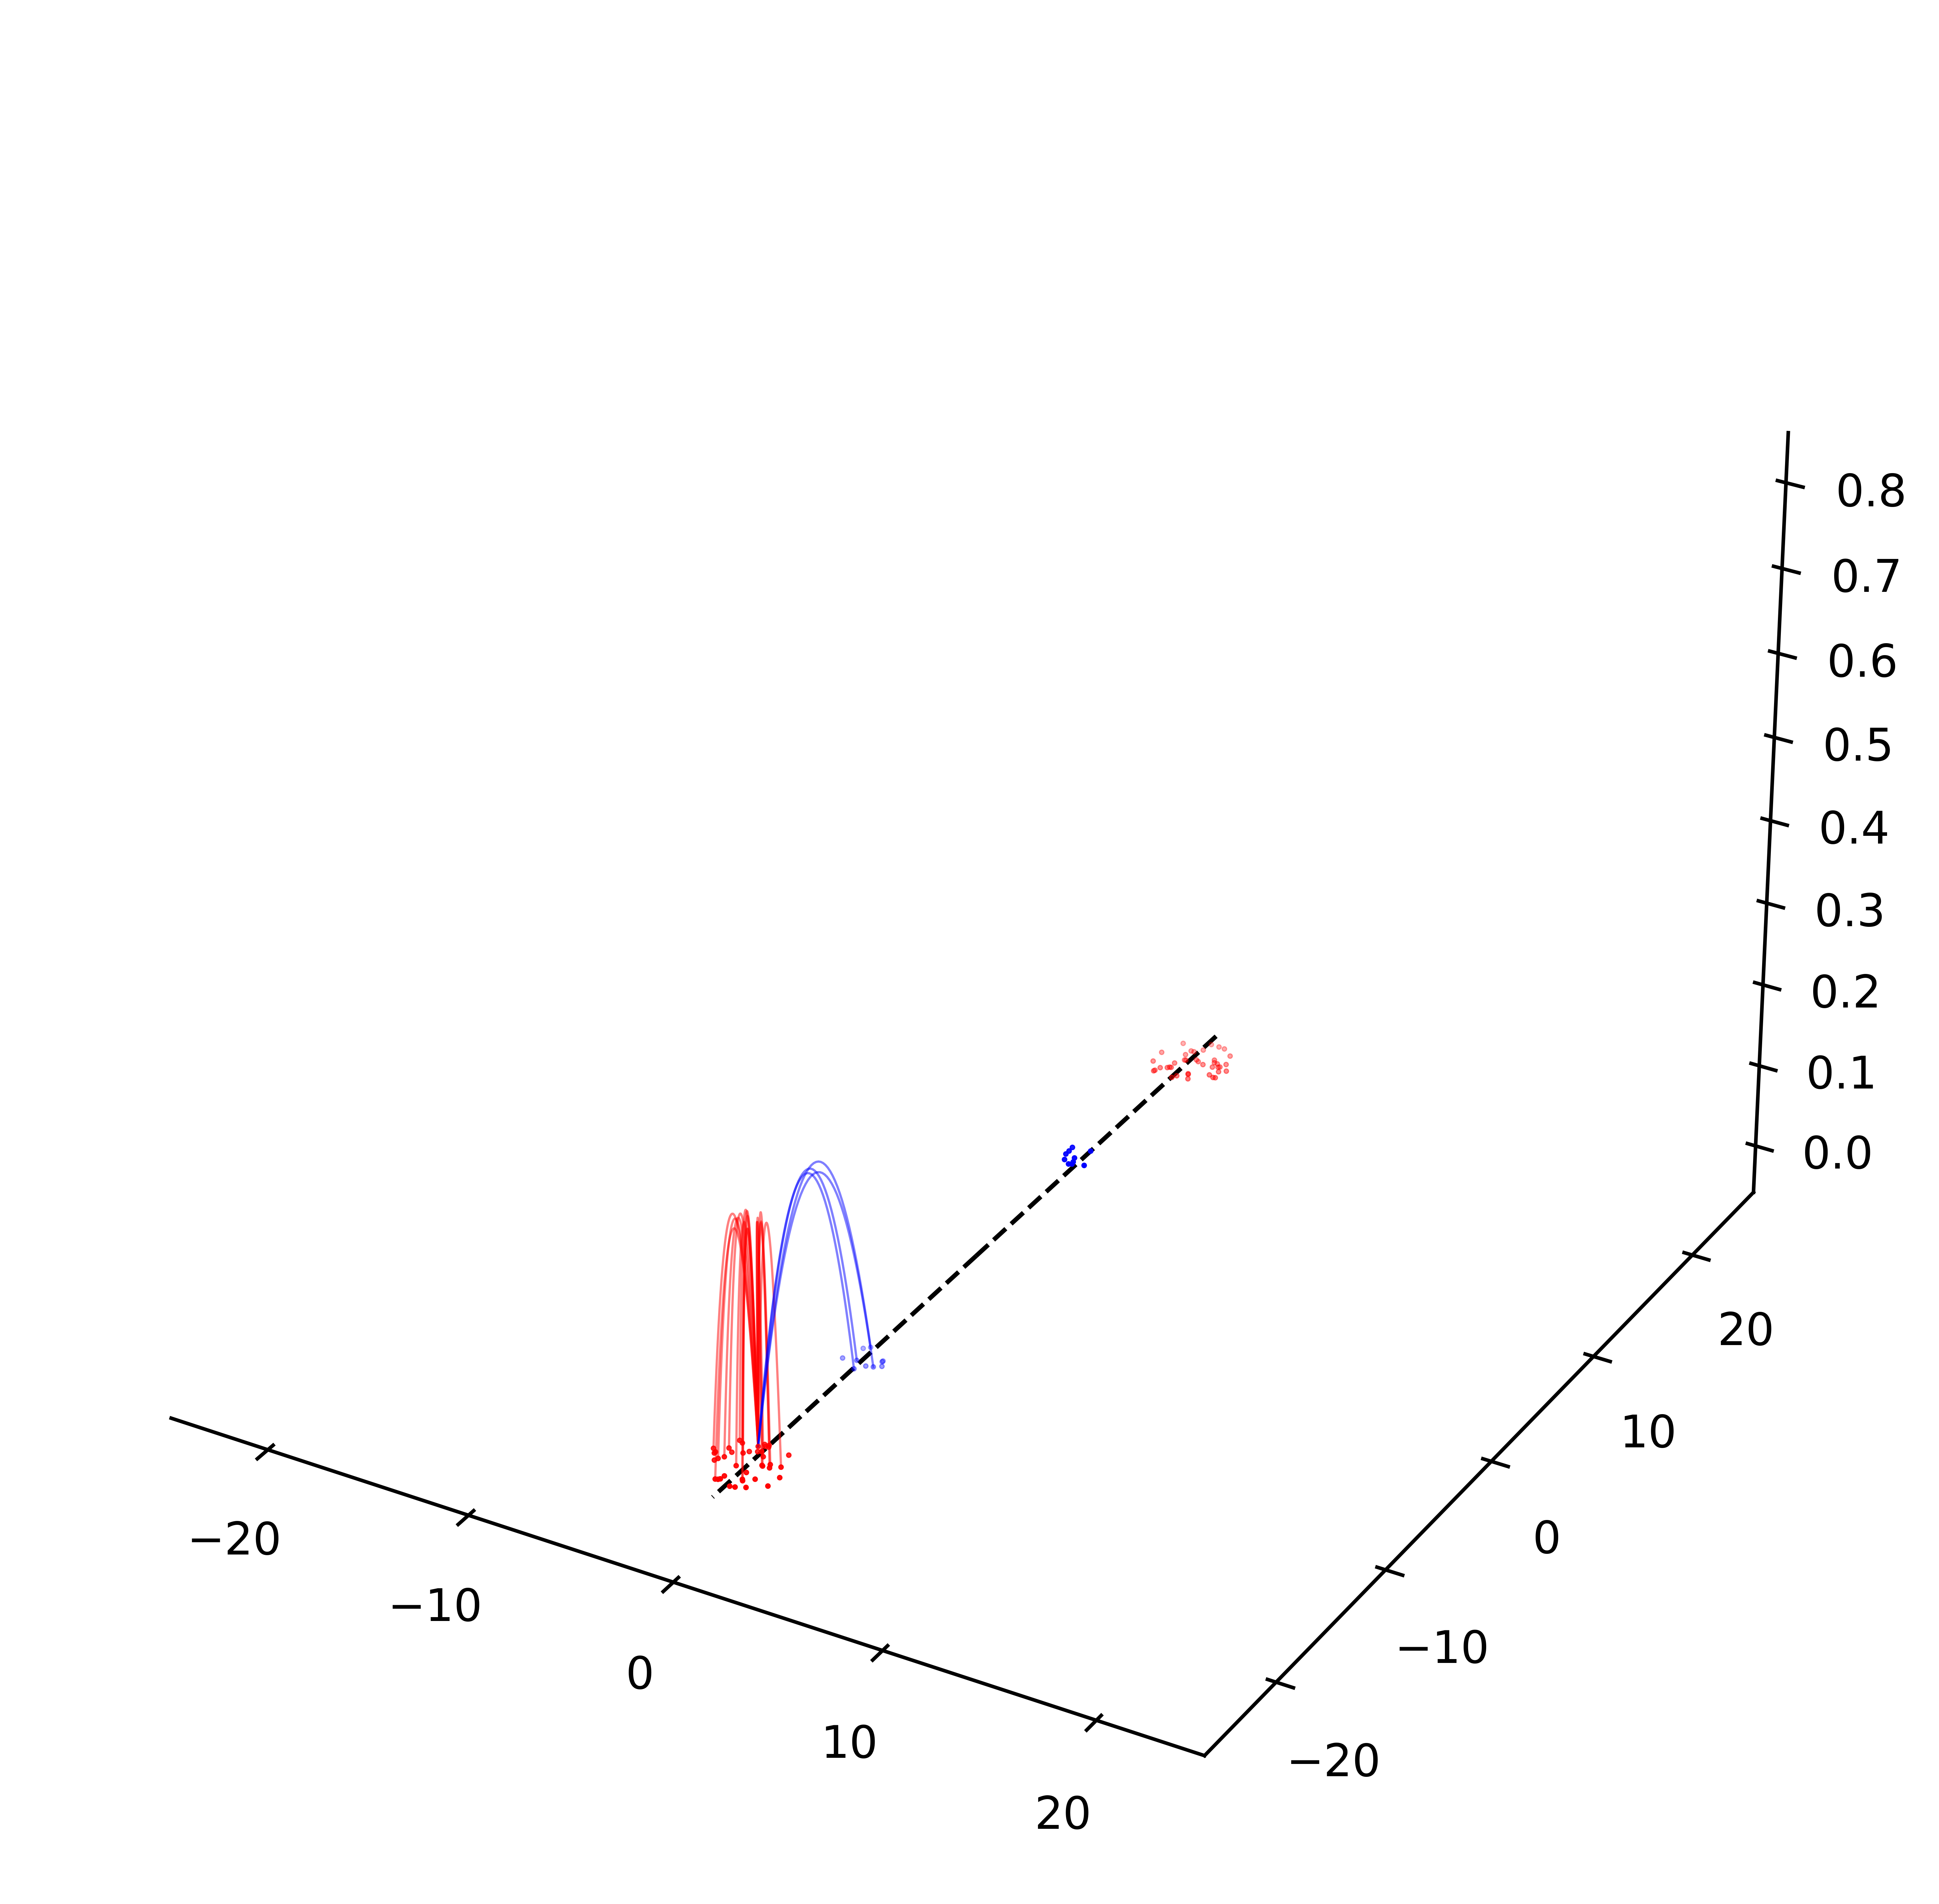

In [177]:
fig,ax = plt.subplots(1,1,figsize=(6,6),dpi=1000,subplot_kw=dict(projection='3d'))

skip = 10
s = 1
npts = 50
ax.scatter(pts[::skip,1],pts[::skip,0],np.zeros(net.N//skip),s=s,lw=s/4,c=colors[::skip],alpha=1e-12)
ax.scatter(pts[:Nperori:skip,1],pts[:Nperori:skip,0],np.zeros(Nperori//skip),
           s=s,lw=s/4,c=colors[:Nperori:skip])
ax.scatter(pts[(Nori//2)*Nperori:(Nori//2+1)*Nperori:skip,1],
           pts[(Nori//2)*Nperori:(Nori//2+1)*Nperori:skip,0],np.zeros(Nperori//skip),
           s=s,lw=s/4,c=colors[(Nori//2)*Nperori:(Nori//2+1)*Nperori:skip])
ax.plot([0,0],[0,radEring+radEpop*1.5],[0,0],'k--',lw=s)
ax.plot([0,0],[0,-(radEring+radEpop*1.5)],[0,0],'k--',lw=s)
rng = np.random.default_rng(0)
peakidx = 0
baseidx = (Nori//2)*Nperori
for i in range(0,Nperori,skip):
    if rng.random() < 0.5:
        h = np.sqrt(1-.8*.9)
        ax.plot(np.linspace(pts[baseidx,1],pts[baseidx+i,1],npts),
                np.linspace(pts[baseidx,0],pts[baseidx+i,0],npts),
                h**2-np.linspace(-h,h,npts)**2,colors[i],lw=s/2,alpha=0.5)
    if rng.random() < 0.5*0.4:
        h = np.sqrt(0.8)
        ax.plot(np.linspace(pts[peakidx,1],pts[baseidx+i,1],npts),
                np.linspace(pts[peakidx,0],pts[baseidx+i,0],npts),
                h**2-np.linspace(-h,h,npts)**2,colors[i],lw=s/2,alpha=1e-12)

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

fig.tight_layout()
fig.savefig('./../plots/reduced_model_base_conn.pdf')

In [179]:
fig,ax = plt.subplots(1,1,figsize=(6,6),dpi=1000,subplot_kw=dict(projection='3d'))

skip = 10
s = 1
npts = 50
ax.scatter(pts[::skip,1],pts[::skip,0],np.zeros(net.N//skip),s=s,lw=s/4,c=colors[::skip],alpha=1e-12)
ax.scatter(pts[:Nperori:skip,1],pts[:Nperori:skip,0],np.zeros(Nperori//skip),
           s=s,lw=s/4,c=colors[:Nperori:skip])
ax.scatter(pts[(Nori//2)*Nperori:(Nori//2+1)*Nperori:skip,1],
           pts[(Nori//2)*Nperori:(Nori//2+1)*Nperori:skip,0],np.zeros(Nperori//skip),
           s=s,lw=s/4,c=colors[(Nori//2)*Nperori:(Nori//2+1)*Nperori:skip])
ax.plot([0,0],[0,radEring+radEpop*1.5],[0,0],'k--',lw=s)
ax.plot([0,0],[0,-(radEring+radEpop*1.5)],[0,0],'k--',lw=s)
rng = np.random.default_rng(2)
peakidx = 0
baseidx = (Nori//2)*Nperori
for i in range(0,Nperori,skip):
    if rng.random() < 0.5*0.7:
        h = np.sqrt(0.8)
        ax.plot(np.linspace(pts[peakidx,1],pts[baseidx+i,1],npts),
                np.linspace(pts[peakidx,0],pts[baseidx+i,0],npts),
                h**2-np.linspace(-h,h,npts)**2,colors[i],lw=s/2,alpha=0.5)
    if rng.random() < 0.5*0.3:
        h = np.sqrt(1-.8*.9)
        ax.plot(np.linspace(pts[peakidx,1],pts[peakidx+i,1],npts),
                np.linspace(pts[peakidx,0],pts[peakidx+i,0],npts),
                h**2-np.linspace(-h,h,npts)**2,colors[i],lw=s/2,alpha=0.5)

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

fig.tight_layout()
fig.savefig('./../plots/reduced_model_peak_conn.pdf')

In [10]:
with open('./../results/dmft_best_fit_c_5.pkl','rb') as\
        handle:
    res_dict = pickle.load(handle)
res_dict['dmft_res']

{'r': array([15.132955, 15.398453, 17.130789, 17.436522], dtype=float32),
 'Cr': array([[ 447.97147,  447.96686,  447.95236, ...,  387.34543,  387.34555,
          387.3455 ],
        [1123.5022 , 1123.4686 , 1123.3683 , ...,  800.2735 ,  800.2727 ,
          800.2718 ],
        [1021.98566, 1021.98004, 1021.9641 , ...,  953.7014 ,  953.7009 ,
          953.7013 ],
        [1514.7418 , 1514.701  , 1514.579  , ..., 1117.0657 , 1117.064  ,
         1117.0626 ]], dtype=float32),
 'dr': array([-1.9978342, -2.0380688], dtype=float32),
 'Cdr': array([[ 660.5177 ,  660.51337,  660.5006 , ...,  556.9808 ,  556.98083,
          556.9802 ],
        [1051.8811 , 1051.8359 , 1051.7004 , ...,  428.5593 ,  428.55798,
          428.55664]], dtype=float32),
 'mu': array([ 0.00915315, -0.00228164,  0.00693332, -0.00399972], dtype=float32),
 'Sig': array([[5.8820307e-05, 5.8818634e-05, 5.8813632e-05, ..., 4.2654556e-05,
         4.2654516e-05, 4.2654472e-05],
        [2.1622278e-04, 2.1621659e-04, 2.161

In [114]:
rb = np.array([15.133126,15.398534])
rp = np.array([78.02721,55.94795])
sr = np.array([16.641127,25.300125])

Crb = np.array([387.83896,801.8631])
Crp = np.array([8555.255,8954.791])
sCr = np.array([14.703152,23.641306])

tau = np.array([ri.tE,ri.tI],dtype=np.float32)
W = J*np.array([[1,-gE],[1./beta,-gI/beta]],dtype=np.float32)
Ks = np.array([K,K/4],dtype=np.float32)
Hb = (bX)*K*J*np.array([hE,hI/beta],dtype=np.float32)
Hp = (bX+aXs[-1])*K*J*np.array([hE,hI/beta],dtype=np.float32)
eH = eX

sH = np.array([SoriF,SoriF])
sH2 = sH**2
muHb = tau*Hb
muHp = tau*Hp
smuH2 = sH2
SigHb = (muHb*eH)**2
SigHp = (muHp*eH)**2
sSigH2 = sH2

muW = tau[:,None]*W*Ks
SigW = tau[:,None]**2*W**2*Ks

sW = np.array([[SoriE,SoriI],[SoriE,SoriI]],dtype=np.float32)
sW2 = sW**2
sr2 = sr**2
sCr2 = sCr**2
sWr2 = sW2+sr2
sWCr2 = sW2+sCr2

mub = muW*rb
mup = mub + np.sqrt(sr2/sWr2)*muW*(rp-rb)
smu2 = sWr2
Sigb = SigW*Crb
Sigp = Sigb + np.sqrt(sCr2/sWCr2)*SigW*(Crp-Crb)
sSig2 = sWCr2

/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_82878/1188594843.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


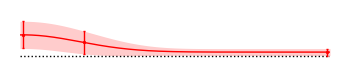

In [155]:
oris = np.linspace(-1,91,361)
suboris = np.array([0,18,90])

def gauss(x,b,p,s2):
    return b + (p-b)*np.exp(-0.5*x**2/s2)

size = 0.5
fig,ax = plt.subplots(1,1,figsize=(4*size,0.5*size),dpi=200)

rE = gauss(oris,rb[0],rp[0],sr[0]**2)
sigrE = np.sqrt(gauss(oris,Crb[0],Crp[0],sCr[0]**2)-\
    gauss(oris,rb[0],rp[0],sr[0]**2)**2)
subrE = gauss(suboris,rb[0],rp[0],sr[0]**2)
subsigrE = np.sqrt(gauss(suboris,Crb[0],Crp[0],sCr[0]**2)-\
    gauss(suboris,rb[0],rp[0],sr[0]**2)**2)
ax.plot(oris,rE,'r',lw=size)
ax.fill_between(oris,rE+sigrE,rE-sigrE,color='r',lw=0,alpha=0.2)
ax.set_xlim(-1,91)
# ax.set_ylim(-1,1.01*(rp[0]+np.sqrt(Crp[0]-rp[0]**2)))
# ax.axvline(0,c='k',ls=(0,(7,5)),lw=size)
# ax.axvline(18,c='k',ls=(0,(7,5)),lw=size)
# ax.axvline(90,c='k',ls=(0,(7,5)),lw=size)
ax.axhline(0,c='k',ls=':',lw=size)
ax.scatter(suboris,subrE,s=2*np.sqrt(size),c='r',lw=0,zorder=4)
ax.errorbar(suboris,subrE,subsigrE,c='r',ls='none',capsize=size,lw=size,capthick=size,zorder=4)

ax.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
ax.axis('off')

fig.tight_layout()
fig.savefig('./../plots/ring_rate_stats.pdf')

/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_82878/3184516076.py:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


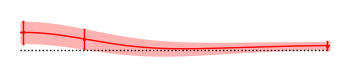

In [154]:
oris = np.linspace(-1,91,361)
suboris = np.array([0,18,90])

def gauss(x,b,p,s2):
    return b + (p-b)*np.exp(-0.5*x**2/s2)

size = 0.5
fig,ax = plt.subplots(1,1,figsize=(4*size,0.5*size),dpi=200)

muE = gauss(oris,mub[0,0],mup[0,0],sWr2[0,0])+\
    gauss(oris,mub[0,1],mup[0,1],sWr2[0,1])+\
    gauss(oris,muHb[0],muHp[0],smuH2[0])
sigE = np.sqrt(gauss(oris,Sigb[0,0],Sigp[0,0],sSig2[0,0])+\
    gauss(oris,Sigb[0,1],Sigp[0,1],sSig2[0,1])+\
    gauss(oris,SigHb[0],SigHp[0],sH2[0]))
submuE = gauss(suboris,mub[0,0],mup[0,0],sWr2[0,0])+\
    gauss(suboris,mub[0,1],mup[0,1],sWr2[0,1])+\
    gauss(suboris,muHb[0],muHp[0],smuH2[0])
subsigE = np.sqrt(gauss(suboris,Sigb[0,0],Sigp[0,0],sSig2[0,0])+\
    gauss(suboris,Sigb[0,1],Sigp[0,1],sSig2[0,1])+\
    gauss(suboris,SigHb[0],SigHp[0],sH2[0]))
ax.plot(oris,muE,'r',lw=size)
ax.fill_between(oris,muE+sigE,muE-sigE,color='r',lw=0,alpha=0.3)
ax.set_xlim(-1,91)
# ax.set_ylim(-0.001,1.01*(mup[0,0]+mup[0,1]+muHp[0]+np.sqrt(Sigp[0,0]+Sigp[0,1]+SigHp[0])))
# ax.axvline(0,c='k',ls=(0,(7,5)),lw=size)
# ax.axvline(18,c='k',ls=(0,(7,5)),lw=size)
# ax.axvline(90,c='k',ls=(0,(7,5)),lw=size)
ax.axhline(0,c='k',ls=':',lw=size)
ax.scatter(suboris,submuE,s=2*np.sqrt(size),c='r',lw=0,zorder=4)
ax.errorbar(suboris,submuE,subsigE,c='r',ls='none',capsize=size,lw=size,capthick=size,zorder=4)

ax.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
ax.axis('off')

fig.tight_layout()
fig.savefig('./../plots/ring_input_stats.pdf')

In [120]:
sigE

array([3.36369176e-04, 3.36433762e-04, 3.36479433e-04, 3.36506180e-04,
       3.36513999e-04, 3.36502888e-04, 3.36472849e-04, 3.36423888e-04,
       3.36356014e-04, 3.36269241e-04, 3.36163584e-04, 3.36039065e-04,
       3.35895707e-04, 3.35733538e-04, 3.35552589e-04, 3.35352894e-04,
       3.35134493e-04, 3.34897427e-04, 3.34641741e-04, 3.34367484e-04,
       3.34074709e-04, 3.33763472e-04, 3.33433832e-04, 3.33085853e-04,
       3.32719601e-04, 3.32335145e-04, 3.31932559e-04, 3.31511920e-04,
       3.31073307e-04, 3.30616805e-04, 3.30142498e-04, 3.29650479e-04,
       3.29140838e-04, 3.28613674e-04, 3.28069086e-04, 3.27507175e-04,
       3.26928049e-04, 3.26331816e-04, 3.25718588e-04, 3.25088480e-04,
       3.24441610e-04, 3.23778099e-04, 3.23098070e-04, 3.22401651e-04,
       3.21688972e-04, 3.20960163e-04, 3.20215361e-04, 3.19454703e-04,
       3.18678330e-04, 3.17886384e-04, 3.17079012e-04, 3.16256360e-04,
       3.15418581e-04, 3.14565827e-04, 3.13698253e-04, 3.12816018e-04,
      